# Ejercicio Práctico: Predicción de Fugas de Clientes (Churn)

El objetivo de este notebook es desarrollar un modelo de aprendizaje automático que anticipe la deserción de clientes en el sector de telecomunicaciones utilizando análisis exploratorio de datos, generación de variables, modelado y técnicas de validación.

En primer lugar, se importarán todas las librerías necesarias para el desarrollo de este ejercicio.

In [107]:
#Importar librerías

import pandas as pd
#!pip install ydata-profiling - Descomentar esta línea si no se tiene la librería instalada
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
#!pip install lime # Descomentar esta línea si no se tiene la librería instalada
from lime.lime_tabular import LimeTabularExplainer

## 1. Carga y compresión del dataset

El dataset fue extraído de [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn), junto con su correspondiente diccionario de variables. Este último es especialmente útil, ya que permite comprender el contexto de los datos, identificar el tipo de información contenida en cada variable y orientar sobre el tratamiento más adecuado que se les debe dar antes de iniciar el proceso de modelado.

In [75]:
#Lee el dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv',delimiter=',')
#Lee el diccionario
datadict = pd.read_excel('datadict.xlsx',header=None)
#Muestra el conjunto de datos
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [76]:
#Muestra el diccionario
datadict.head(21)

,0,1
0,customerID,Customer ID
1,gender,Whether the customer is a male or a female
2,SeniorCitizen,Whether the customer is a senior citizen or no...
3,Partner,Whether the customer has a partner or not (Yes...
4,Dependents,Whether the customer has dependents or not (Ye...
5,tenure,Number of months the customer has stayed with ...
6,PhoneService,Whether the customer has a phone service or no...
7,MultipleLines,Whether the customer has multiple lines or not...
8,InternetService,"Customer’s internet service provider (DSL, Fib..."
9,OnlineSecurity,Whether the customer has online security or no...


Una vez revisado el diccionario de datos y comprendida la naturaleza del dataset, el siguiente paso consiste en identificar el tipo de variable correspondiente a cada atributo, así como determinar la cantidad de valores nulos presentes en ellos.

In [77]:
# Identificar tipos de variables
print("Tipos de variables:")
print(data.dtypes)

# Identificar presencia de valores faltantes
print("\nValores faltantes por columna:")
print(data.isnull().sum())

Tipos de variables:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Valores faltantes por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract        

De este primer análisis se concluye lo siguiente:

* El conjunto de datos está compuesto por 21 variables, que incluyen tanto atributos categóricos como numéricos, además de la variable objetivo: Churn.
* La mayoría de los atributos corresponden a variables categóricas, lo que hará necesario aplicar técnicas de transformación y codificación (como OneHotEncoding o LabelEncoding) antes del modelado.
* Variables como `tenure`, `SeniorCitizen` y `MonthlyCharges` son numéricas, mientras que `TotalCharges` aparece como object pese a representar valores monetarios, por lo que será necesario convertirla a tipo numérico y verificar posibles inconsistencias (espacios en blanco, registros vacíos).
* En cuanto a los valores faltantes, no se identificaron datos nulos explícitos en el dataset; sin embargo, este aspecto se validará nuevamente durante el análisis exploratorio de datos (EDA).

En resumen, el dataset presenta un buen nivel de completitud, aunque será indispensable realizar un proceso de revisión y transformación de las variables categóricas y numéricas, con el fin de garantizar un entrenamiento adecuado y confiable de los modelos de machine learning.


## 2. Análisis exploratorio (EDA)

En esta sección se realizará el **Análisis Exploratorio de Datos (EDA)** con el fin de comprender mejor la estructura del dataset, identificar patrones iniciales, distribuciones de variables, posibles valores atípicos y relaciones entre las variables independientes y la variable objetivo (`Churn`).  
Este paso es clave, ya que permitirá orientar el preprocesamiento y la selección de técnicas de modelado más adecuadas.


In [78]:
#Objeto de EDA
profile = ProfileReport(data, title="Análisis exploratorio", explorative=True)

# Mostrar en notebook
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:01<00:00, 19.86it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Del reporte de análisis exploratorio es importante recalcar que:


* El conjunto de datos contiene 7043 registros lo que representa un volumen manejable para aplicar análisis exploratorio y modelos de machine learning.
* `customerID` es un identificador único, sin valor predictivo, por lo que será eliminada del análisis.
* `SeniorCitizen` ya se encuentra codificada como binaria (0 = No, 1 = Sí), por lo que no requiere transformación adicional.
* Variables como `Partner`, `Dependents`, `PhoneService`, entre otras categóricas, deberán transformarse mediante técnicas de codificación como OneHotEncoding.
* `tenure` presenta valores extremos en 0 (clientes recién adquiridos) y 72 (clientes con permanencia máxima registrada). Se recomienda verificar si se consideran atípicos o si representan la realidad del negocio.
* `MonthlyCharges` muestra variabilidad amplia; conviene analizar su distribución e identificar posibles valores atípicos.
* `TotalCharges` está almacenada como texto (object), por lo que es necesario convertirla a formato numérico y revisar si existen registros con espacios en blanco u otros caracteres no válidos.
* La variable objetivo `(churn)` está desbalanceada (más clientes que permanecen que los que se dan de baja). Este desequilibrio puede afectar el rendimiento de los modelos, por lo que se evaluarán técnicas de balanceo como sobremuestreo (SMOTE), submuestreo o se tendrá en cuenta al momento de crear el modelo.

En cuanto a la matriz de correlación es posible afirmar que:

* Existen correlaciones fuertes entre servicios relacionados:  
  - `InternetService` con `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` y `StreamingMovies`.  
  - Esto refleja que los clientes que tienen internet suelen contratar (o no) servicios adicionales.
* `MonthlyCharges` se correlaciona con la contratación de servicios adicionales (`StreamingTV`, `StreamingMovies`, `TechSupport`, etc.). A mayor cantidad de servicios, mayor es el valor de la factura mensual.
* `Churn` (deserción) presenta correlaciones relevantes con:  
  - `Contract`: clientes con contratos más largos suelen permanecer más tiempo.  
  - `tenure`: mayor permanencia reduce la probabilidad de abandono.  
  - `MonthlyCharges`: facturas mensuales altas podrían estar asociadas a una mayor deserción.
* Variables como `gender` y `SeniorCitizen` muestran baja correlación con `Churn`, lo que indica que probablemente no serán predictores fuertes de forma individual.

## 3. Limpieza y transformación

En esta sección se llevará a cabo la limpieza y transformación del dataset, etapa fundamental antes de aplicar cualquier técnica de modelado.
El objetivo es garantizar que los datos estén en un formato adecuado, libre de inconsistencias y correctamente codificados.  
Para ello, se realizarán acciones como la eliminación de variables irrelevantes, conversión de tipos de datos, tratamiento de valores atípicos y codificación de variables categórica.

Por otra parte, el proceso de limpieza y transformación de los datos dependerá en gran medida de los modelos que se entrenarán:

- **Modelo base: Árbol de Decisión**  
  - No requiere escalado de variables numéricas, ya que los árboles dividen en función de umbrales y no de distancias.  
  - Sí requiere la conversión de variables categóricas a valores numéricos (OneHotEncoding o LabelEncoding).  
  - Es relativamente robusto frente a valores atípicos.  

- **Modelo avanzado: Random Forest**  
  - Al ser un ensamble de múltiples árboles de decisión, mantiene las mismas características que el árbol simple:  
    - No necesita escalado de variables.  
    - Requiere codificación de variables categóricas.  
    - Es menos sensible a ruido y outliers gracias a la votación de múltiples árboles.  

**Por lo tanto, no se eliminarán outliers y ambos modelos pueden compartir la misma transformación de datos**.

Antes de empezar con el proceso de limpieza y transformación se hará una copia del dataset.

In [79]:
#Copia del dataset
data_raw = data.copy()

### 3.1. Eliminación de variables irrelevantes

La variable `customerID` es un identificador que no aporta a la tarea de clasificación.

In [80]:
# Eliminar la variable customerID
data_raw = data_raw.drop('customerID', axis=1)
data_raw.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 3.2. Formatear variables

En esta etapa se garantiza que todas las variables cuenten con el formato adecuado para su análisis, asegurando coherencia en los tipos de datos y facilitando las transformaciones posteriores.

In [81]:
# Reemplaza espacios en blanco por NaN
data_raw["TotalCharges"] = data_raw["TotalCharges"].replace(" ", pd.NA)

# Convertir a tipo numérico (float)
data_raw["TotalCharges"] = pd.to_numeric(data_raw["TotalCharges"])

# Verificar cambios
print("\nNúmero de datos faltantes para TotalCharges:")
print(data_raw["TotalCharges"].isna().sum())
print("\nTipo de datos del dataset:")
print(data_raw.dtypes)
print("\nValores faltantes por columna:")
print(data_raw.isnull().sum())


Número de datos faltantes para TotalCharges:
11

Tipo de datos del dataset:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Valores faltantes por columna:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies   

### 3.3. Eliminación valores nulos

La única columna con valores faltantes corresponde a `TotalCharges`, donde se identificaron 11 registros nulos. Dado que el dataset cuenta con un total de 7043 observaciones, la eliminación de estos registros representa un impacto mínimo y no afecta la calidad del análisis.

In [82]:
#Elimina los valores nulos
data_raw = data_raw.dropna(subset=["TotalCharges"])

#Verificación
print("\nValores faltantes por columna:")
print(data_raw.isnull().sum())


Valores faltantes por columna:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 3.4. División del dataset y transformación OneHotEncoding

En esta etapa es fundamental realizar la división train/test, asegurando que los datos de prueba permanezcan intactos hasta el momento de la evaluación del modelo.   Para garantizar reproducibilidad, se empleará una partición del **80% para entrenamiento y 20% para prueba**, con un `random_state = 0`.

Dado que los modelos seleccionados requieren que todas las variables estén en formato numérico, las variables categóricas nominales serán transformadas mediante `OneHotEncoding`. Dado que los objetos de scikitlearn reciben la variable objetivo de forma categórica no es necesaria transformarla.

Adicionalmente, la variable objetivo (`Churn`) se encuentra desbalanceada, por lo que se tendrá en cuenta al momento de crear el modelo.


In [83]:
# División del conjunto de datos
X = data_raw.drop("Churn", axis=1)
y = data_raw["Churn"]               # variable objetivo

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% test
    random_state=0,       # garantiza replicabilidad
    stratify=y            # mantiene la proporción de clases de Churn
)

# Variables categóricas
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

#Variable numéricas
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()
num_cols.remove("SeniorCitizen") #Esta variable ya está transformada

#Objeto OneHotEncoding
encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)

### 3.5. Creación del pipeline para el modelo de Árboles de Decisión

En este paso se construirá un pipeline que incluirá la transformación de las variables categóricas (distintas a la variable objetivo) mediante `OneHotEncoding`, así como la creación del modelo base de **Árbol de Decisión**.

Este pipeline permitirá integrar en un solo flujo tanto el preprocesamiento como el entrenamiento del modelo, lo que facilita su ejecución y asegura coherencia en la aplicación de las transformaciones.  

Además, el pipeline será la base para realizar posteriormente la búsqueda de hiperparámetros `(GridSearchCV)`.


In [84]:
#Proceso de transformación de variables categóricas
preprocess_dt = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_cols),
        ("num", "passthrough", num_cols) #A las numéricas, no le hace nada
    ],
    remainder="drop"
)

# Modelo base: Árbol de Decisión
decision_tree = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced"  #Tiene en cuenta el desbalance
)

# Pasos del pipeline
steps_dt = [
    ("prep", preprocess_dt),
    ("model", decision_tree)
]

# Pipeline
dt_pipeline = Pipeline(steps_dt).set_output(transform="pandas")
dt_pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=0))])

### 3.6. Creación del pipeline para el modelo de Random Forest

En este paso se construirá un pipeline que incluirá la transformación de las variables categóricas (distintas a la variable objetivo) mediante OneHotEncoding, así como la creación del modelo base de Random Forest.

Este pipeline permitirá integrar en un solo flujo tanto el preprocesamiento como el entrenamiento del modelo, lo que facilita su ejecución y asegura coherencia en la aplicación de las transformaciones.

Además, el pipeline será la base para realizar posteriormente la búsqueda de hiperparámetros (GridSearchCV).

In [85]:
#Proceso de transformación de variables categóricas
preprocess_rf = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)

# Modelo base Random Forest
random_forest = RandomForestClassifier(
    random_state=0,
    class_weight="balanced",
    n_jobs=-1
)

# Pasos del pipeline
steps_rf = [
    ("prep", preprocess_rf),
    ("model", random_forest)
]

# Pipeline
rf_pipeline = Pipeline(steps_rf).set_output(transform="pandas")
rf_pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=0))])

## 4. Modelado predictivo

En esta etapa se realizará un `GridSearchCV` por cada modelo (Árbol de Decisión y Random Forest) usando validación cruzada estratificada. Se calcularán múltiples métricas durante la búsqueda (**F1-score** y **ROC AUC**), pero la selección del mejor conjunto de hiperparámetros se hará con `refit="f1"` debido al desbalance de `Churn`.  

Una vez seleccionado el mejor modelo, se reportarán en el conjunto de prueba** todas las métricas solicitadas:
- F1-score
- ROC AUC
- Matriz de confusión
- Curvas ROC y Precision-Recall (PR)


### 4.1. GridSearchCV para Árbol de Decisión

En esta sección se realiza una búsqueda de hiperparámetros (GridSearchCV) para el modelo de Árbol de Decisión, utilizando un pipeline que combina el preprocesamiento y el clasificador. Para la evaluación se emplea una validación cruzada estratificada de 5 particiones, lo que garantiza que la proporción de clases se mantenga en cada fold. Se optimizan diferentes parámetros del árbol (criterio, profundidad máxima y tamaño mínimo de nodos) y se calculan métricas relevantes como F1-score y ROC AUC, priorizando el F1 como métrica principal debido al desbalance de la variable objetivo.

In [86]:
# Métricas para el GridSearch
scoring = {
    "f1": make_scorer(f1_score, pos_label=1 if y_train.dtype != "O" else "Yes"),
    "roc_auc": "roc_auc"
}

# Grilla de hiperparámetros para DecisionTreeClassifier dentro de pipe_dt
dt_param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [ 4, 6, 8, 10, 12, 16],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

# Validación cruzada estratificada por el desbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# GridSearchCV
dt_gridsearch = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid,
    scoring=scoring,
    refit="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

# Entrenar búsqueda
dt_gridsearch.fit(X_train, y_train)
print("Mejores parámetros: {}".format(dt_gridsearch.best_params_))
print("Mejor F1 en CV:", dt_gridsearch.best_score_)

#Obtiene el mejor modelo
mejor_dt = dt_gridsearch.best_estimator_
mejor_dt

Mejores parámetros: {'model__criterion': 'entropy', 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Mejor F1 en CV: 0.6194600880892274


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=4,
                                        random_state=0))])

Tras realizar la búsqueda de hiperparámetros con validación cruzada estratificada, el **Árbol de Decisión** obtuvo como mejor configuración:

- `criterion`: entropy
- `max_depth`: 4
- `min_samples_split`: 2
- `min_samples_leaf`: 1

Con estos parámetros, el modelo alcanzó un `F1-score` promedio en validación cruzada de 0.619, lo que indica un desempeño inicial aceptable considerando el desbalance de la variable objetivo `Churn`.

Este resultado muestra que un árbol poco profundo (profundidad = 4) logra un equilibrio razonable entre simplicidad del modelo y capacidad predictiva, evitando un sobreajuste excesivo.

### 4.2. GridSearch para Random Forest

De manera análoga al Árbol de Decisión, se aplicó un `GridSearchCV` para optimizar los hiperparámetros más relevantes del modelo de Random Forest.  
Dado que se trata de un ensamble de múltiples árboles, los hiperparámetros clave que influyen en su desempeño son:

- `n_estimators`: número de árboles en el bosque.  
- `max_depth`: profundidad máxima de cada árbol.  
- `min_samples_split`: número mínimo de muestras para dividir un nodo.  
- `min_samples_leaf`: número mínimo de muestras en una hoja.  
- `max_features`: número de variables consideradas al dividir cada nodo.  

La búsqueda se realizará con validación cruzada estratificada, evaluando las métricas **F1-score** y **ROC AUC**, y seleccionando el mejor modelo con base en el **F1-score** debido al desbalance de la variable objetivo.


In [87]:
# Grilla de hiperparámetros
rf_param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [ 6, 10, 16],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", "log2"]
}

# GridSearchCV
rf_gridsearch = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring=scoring,
    refit="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

# Entrenar búsqueda
rf_gridsearch.fit(X_train, y_train)

print("Mejores parámetros:", rf_gridsearch.best_params_)
print("Mejor F1 en CV:", rf_gridsearch.best_score_)

# Mejor modelo
mejor_rf = rf_gridsearch.best_estimator_
mejor_rf

Mejores parámetros: {'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Mejor F1 en CV: 0.6377290898986505


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='log2',
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=0))])

Tras realizar la búsqueda de hiperparámetros con validación cruzada estratificada, el Random Forestalcanzó como mejor configuración:

- `n_estimators`: 100
- `max_depth`: 10
- `min_samples_split`: 10
- `min_samples_leaf`: 1
- `max_features`: log2

Con esta combinación, el modelo logró un F1-score promedio en validación cruzada de 0.638, ligeramente superior al obtenido con el Árbol de Decisión.  

El resultado sugiere que el Random Forest, al combinar múltiples árboles con una profundidad controlada (`max_depth=10`) y seleccionando aleatoriamente subconjuntos de características (`max_features=log2`), logra una mejor capacidad de generalización frente al árbol individual, manteniendo un balance adecuado entre sesgo y varianza.


## 5. Evaluación de los modelos

Una vez seleccionados los mejores hiperparámetros mediante `GridSearchCV`, el siguiente paso consiste en evaluar el desempeño de cada modelo en el conjunto de prueba.  
Este análisis permite medir la capacidad de generalización de los modelos y comparar de manera objetiva el rendimiento del **Árbol de Decisión** (modelo base) frente al **Random Forest** (modelo avanzado).

Para la evaluación se emplearán diversas métricas complementarias, que ofrecen una visión integral del desempeño:

- **Matriz de confusión**: distribución de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.  
- **F1-score**: balance entre precisión y exhaustividad, especialmente útil en escenarios con desbalance de clases.  
- **ROC AUC**: capacidad del modelo para discriminar entre clases a distintos umbrales de decisión.  
- **Curva ROC**: relación entre la tasa de verdaderos positivos y la tasa de falsos positivos.  
- **Curva Precision-Recall (PR)**: evaluación de la precisión frente al recall, útil en datasets desbalanceados.

De esta forma se podrá determinar no solo cuál modelo ofrece mejor rendimiento, sino también cuál resulta más adecuado para el problema de predicción de deserción de clientes (`Churn`).


### 5.1. Evaluación Árbol de Decisión

=== MATRIZ DE CONFUSIÓN ===
[[759 274]
 [ 84 290]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1033
         Yes       0.51      0.78      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.75      0.76      1407


=== ROC AUC ===
0.8256971802185629


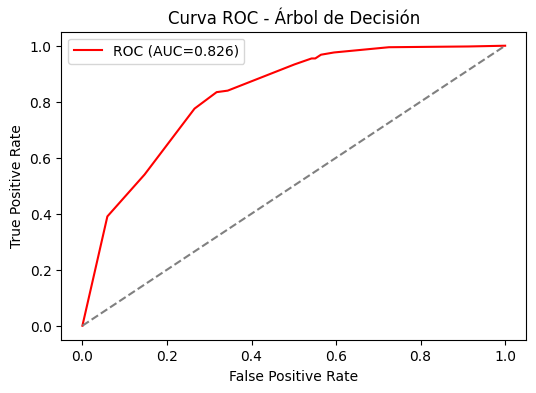

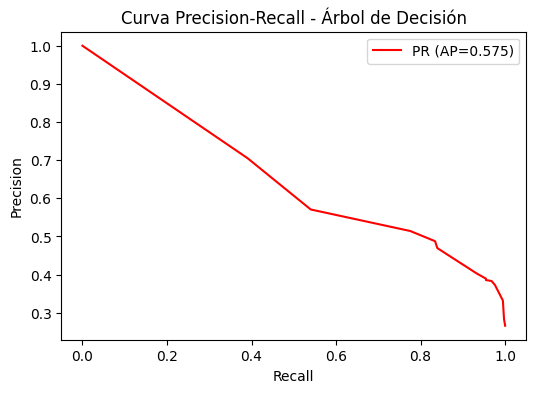

In [88]:
# Clase positiva según target en texto
POS = "Yes"

# Evaluación
y_pred_dt  = mejor_dt.predict(X_test)
y_proba_dt = mejor_dt.predict_proba(X_test)[:, 1]  # prob de 'Yes'

print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred_dt))

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred_dt))

# ROC AUC (no necesita pos_label si pasas proba de la clase positiva)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("\n=== ROC AUC ===")
print(roc_auc_dt)

# Curva ROC (¡aquí sí especifica pos_label!)
fpr, tpr, _ = roc_curve(y_test, y_proba_dt, pos_label=POS)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_dt:.3f})",color="red")
plt.plot([0,1], [0,1], ls="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión"); plt.legend(); plt.show()

# Curva Precision-Recall (también con pos_label)
prec, rec, _ = precision_recall_curve(y_test, y_proba_dt, pos_label=POS)
ap = average_precision_score(y_test, y_proba_dt, pos_label=POS)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})", color = "red")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Árbol de Decisión"); plt.legend(); plt.show()


### 5.2. Evaluación Random Forest

=== MATRIZ DE CONFUSIÓN ===
[[810 223]
 [ 97 277]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

          No       0.89      0.78      0.84      1033
         Yes       0.55      0.74      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407


=== ROC AUC ===
0.8483157409756121


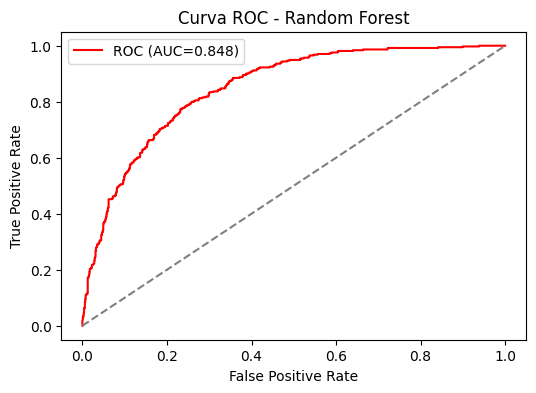

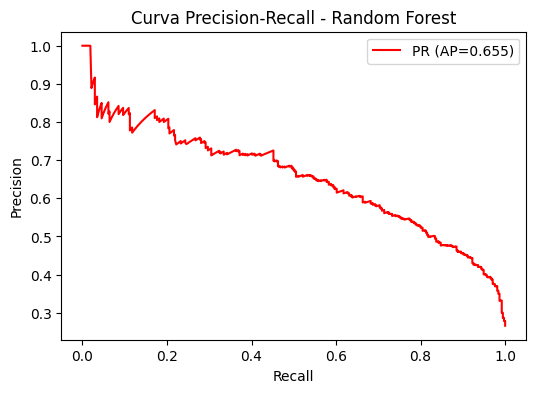

In [90]:
# Clase positiva según target en texto
POS = "Yes"

# Probabilidades y predicciones
y_pred_rf  = mejor_rf.predict(X_test)
y_proba_rf = mejor_rf.predict_proba(X_test)[:, 1]  # prob de 'Yes'

# Matriz de confusión
print("=== MATRIZ DE CONFUSIÓN ===")
print(confusion_matrix(y_test, y_pred_rf))

# Reporte de clasificación
print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred_rf))

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("\n=== ROC AUC ===")
print( roc_auc_rf)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf, pos_label=POS)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_rf:.3f})", color="red")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.show()

# Curva Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba_rf, pos_label=POS)
ap = average_precision_score(y_test, y_proba_rf, pos_label=POS)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})",color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Random Forest")
plt.legend()
plt.show()


### 5.3. Comparación entre modelos

In [95]:
# ===== Métricas por modelo =====
metrics = {
    "Árbol de Decisión": {
        "Precision": precision_score(y_test, y_pred_dt, pos_label=POS),
        "Recall":    recall_score(y_test, y_pred_dt, pos_label=POS),
        "F1":        f1_score(y_test, y_pred_dt, pos_label=POS),
        "ROC AUC":   roc_auc_score(y_test, y_proba_dt),
        "PR AUC":    average_precision_score(y_test, y_proba_dt, pos_label=POS)
    },
    "Random Forest": {
        "Precision": precision_score(y_test, y_pred_rf, pos_label=POS),
        "Recall":    recall_score(y_test, y_pred_rf, pos_label=POS),
        "F1":        f1_score(y_test, y_pred_rf, pos_label=POS),
        "ROC AUC":   roc_auc_score(y_test, y_proba_rf),
        "PR AUC":    average_precision_score(y_test, y_proba_rf, pos_label=POS)
    }
}

res = pd.DataFrame(metrics).T.round(3).sort_values("F1", ascending=False)
res

,Precision,Recall,F1,ROC AUC,PR AUC
Random Forest,0.554,0.741,0.634,0.848,0.655
Árbol de Decisión,0.514,0.775,0.618,0.826,0.575


## 6. Interpretabilidad

Además de evaluar el rendimiento, es fundamental analizar la interpretabilidad de los modelos, ya que permite comprender qué variables influyen en la predicción del abandono de clientes `(Churn)` y justificar las decisiones tomadas por el modelo.

Se aplicarán dos enfoques complementarios:

- **Importancia global de variables**: identifica qué características tienen mayor peso en el modelo (ejemplo: `Contract`, `tenure`, `MonthlyCharges`).  
- **Explicación local de predicciones**: mediante herramientas como **SHAP** o **LIME**, que permiten entender qué factores explican la decisión del modelo para un cliente específico.


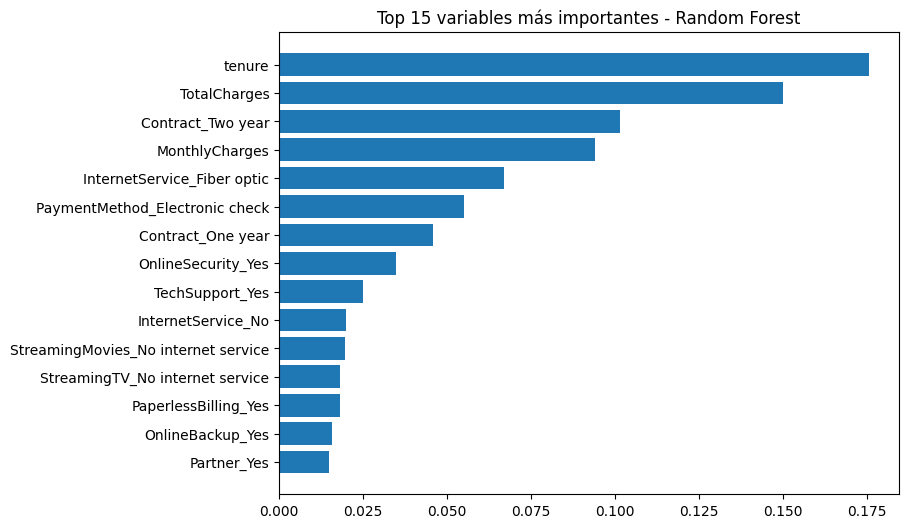

,Feature,Importance
26,tenure,0.175867
28,TotalCharges,0.150118
21,Contract_Two year,0.101615
27,MonthlyCharges,0.094123
6,InternetService_Fiber optic,0.067014
24,PaymentMethod_Electronic check,0.055184
20,Contract_One year,0.045890
9,OnlineSecurity_Yes,0.034778
15,TechSupport_Yes,0.025012
7,InternetService_No,0.019882


In [97]:
# Extraer importancias desde el mejor Random Forest
rf_model = mejor_rf.named_steps["model"]

# Recuperar nombres de variables después del OneHotEncoder
feature_names_cat = mejor_rf.named_steps["prep"].transformers_[0][1].get_feature_names_out(cat_cols)
feature_names = np.concatenate([feature_names_cat, num_cols])

# Importancias
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False).head(15)

# Visualización
plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 variables más importantes - Random Forest")
plt.show()

feat_imp

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


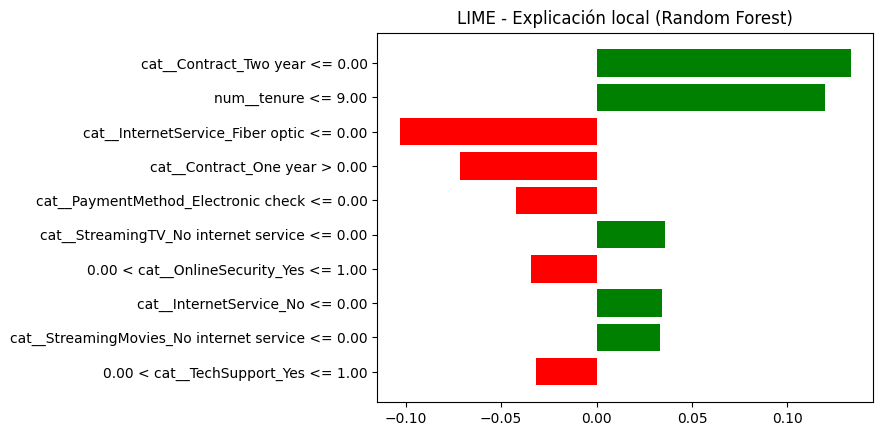

In [113]:
# Pipeline
prep   = mejor_rf.named_steps["prep"]
model  = mejor_rf.named_steps["model"]

# Entrenamiento para LIME
X_train_tr = prep.transform(X_train)
# sparse -> denso
if hasattr(X_train_tr, "toarray"):
    X_train_tr = X_train_tr.toarray()
# DataFrame -> NumPy
if isinstance(X_train_tr, pd.DataFrame):
    X_train_tr = X_train_tr.to_numpy()
# asegurar 2D
X_train_tr = np.asarray(X_train_tr)
if X_train_tr.ndim == 1:
    X_train_tr = X_train_tr.reshape(1, -1)

feature_names = list(prep.get_feature_names_out())
class_names   = list(model.classes_)  # p.ej. ['No','Yes']

explainer = LimeTabularExplainer(
    training_data=X_train_tr,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True
)

# Wrapper
def predict_proba_tr(X):
    # LIME puede mandar DataFrame o ndarray; convertimos todo a NumPy 2D
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    return model.predict_proba(X)

#Elegir una muestra del TEST y transformarla
i = 5
x_test_tr = prep.transform(X_test.iloc[[i]])
if hasattr(x_test_tr, "toarray"):
    x_test_tr = x_test_tr.toarray()
if isinstance(x_test_tr, pd.DataFrame):
    x_test_tr = x_test_tr.to_numpy()
x_test_tr = np.asarray(x_test_tr)
if x_test_tr.ndim == 1:
    x_test_tr = x_test_tr.reshape(1, -1)

# Explicar con LIME
exp = explainer.explain_instance(
    data_row=x_test_tr[0],
    predict_fn=predict_proba_tr,
    num_features=10
)

# Mostrar en Matplotlib
import matplotlib.pyplot as plt
fig = exp.as_pyplot_figure()
plt.title("LIME - Explicación local (Random Forest)")
plt.show()


**Importancias globales – Random Forest**

* `tenure` es la variable con mayor peso. En este problema suele cumplirse que menos tiempo de permanencia ⇒ mayor probabilidad de churn.

* `TotalCharges` y `MonthlyCharges` también son muy relevantes: facturas altas suelen asociarse a mayor deserción.

* Tipo de contrato: tener `Contract_Two` year (dos años) aparece como fuerte predictor; en general contratos de mayor permanencia reducen el churn, mientras que `month-to-month` lo incrementa.

* `InternetService_Fiber` optic pesa más que el resto de categorías de Internet. En el dataset Telco típico, fiber optic tiende a mostrar más churn que DSL.

* `PaymentMethod_Electronic` check: este método suele incrementar el churn frente a otros (p. ej., transferencia automática).

**Explicación local – LIME (cliente del índice graficado)**

* En la barra de LIME, verde empuja hacia la clase predicha (probablemente Churn=Yes si ese fue el resultado) y rojo en contra.

* `cat__Contract_Two` year <= 0.00 (verde): el cliente no tiene contrato a 2 años ⇒ aumenta el churn.

* `num__tenure` <= 9.00 (verde): baja permanencia ⇒ aumenta el churn (coherente con la intuición).

* `cat__InternetService_Fiber` optic <= 0.00 (rojo): no tiene fibra óptica ⇒ reduce el churn para este caso (tener fibra suele asociarse con más deserción).

* `cat__Contract_One` year > 0.00 (rojo): sí tiene contrato de 1 año ⇒ reduce el churn.

* `cat__PaymentMethod_Electronic` check <= 0.00 (rojo): no paga con cheque electrónico ⇒ reduce el churn (pagar con cheque electrónico suele aumentar el riesgo).

* `cat__OnlineSecurity_Yes` (rojo) y `cat__TechSupport_Yes` (rojo): tener estos servicios disminuye el riesgo de churn.

Pequeños empujes verdes (p. ej., StreamingTV_No internet service <= 0.00, StreamingMovies_No internet service <= 0.00) indican que sí tiene esos servicios, lo cual en este individuo eleva ligeramente la probabilidad de churn.

## 7. Resumen ejecutivo

### Objetivo
Construir un modelo que anticipe la deserción (Churn) de clientes telco para priorizar acciones de retención.

### Datos y EDA (síntesis)
- 7043 registros; mayoría de variables categóricas (servicios/contrato) y algunas numéricas (`tenure`, `MonthlyCharges`, `TotalCharges`).
- `TotalCharges` venía como texto → convertido a float y sin nulos tras limpieza.
- `Churn` desbalanceado (clase positiva minoritaria).
- Patrones clave:
  - Menor `tenure` y contratos “month-to-month” riesgo de churn.
  - `MonthlyCharges` y `TotalCharges` alto riesgo.
  - Servicios como `OnlineSecurity` y `TechSupport` bajo riesgo.
  - Método de pago `Electronic check` se asocia a mayor churn.

### Preparación y metodología
- Limpieza básica: quitar `customerID`, tipado de `TotalCharges`.
- Split 80/20 estratificado.
- `OneHotEncoding` para categóricas; numéricas “passthrough”.
- Modelos:
  - **Base:** Decision Tree (`class_weight="balanced"`).
  - **Avanzado:** Random Forest (`class_weight="balanced"`).
- **GridSearchCV** con validación cruzada estratificada; métricas calculadas **F1** y **ROC AUC**; selección por `refit="f1"`.

### Resultados (validación cruzada)
- **Decision Tree** — mejores params: `criterion=entropy`, `max_depth=4`, `min_samples_split=2`, `min_samples_leaf=1`.  
  **F1-CV ≈ 0.619**.
- **Random Forest** — mejores params: `n_estimators=100`, `max_depth=10`, `min_samples_split=10`, `min_samples_leaf=1`, `max_features=log2`.  
  **F1-CV ≈ 0.638**.
- En **test**, el Random Forest supera al árbol en **F1** y **ROC AUC** (ver tablas/gráficos en la sección de evaluación).

### Interpretabilidad (¿qué impulsa el churn?)
- **Variables más influyentes (RF):** `tenure`, `TotalCharges`, `MonthlyCharges`, tipo de `Contract`, `PaymentMethod_Electronic check`, `InternetService_Fiber optic`.
- **Protectores:** `OnlineSecurity_Yes`, `TechSupport_Yes`, contratos de **1/2 años**.
- **LIME** (explicación local): en casos con **bajo tenure** y **sin contrato largo**, la probabilidad de churn aumenta; servicios de seguridad/soporte reducen el riesgo.

### Recomendaciones accionables
1. **Retención temprana**: trigger para clientes **< X meses de tenure** y **contrato month-to-month** → ofertas de permanencia, upsell de “bundle” con descuento.
2. **Migración de contrato**: incentivar **contratos de 1 o 2 años** con beneficios (precio fijo, meses gratis de servicio premium).
3. **Gestión de precio**: revisar **MonthlyCharges** elevados; ofrecer planes optimizados o descuentos por fidelidad.
4. **Método de pago**: promover cambio desde **Electronic check** a **débito automático** / transferencia con incentivos.
5. **Upsell de servicios protectores**: **OnlineSecurity/TechSupport** como add-ons con prueba gratis para segmentos de alto riesgo.
6. **Alerta operativa**: desplegar un **score de churn** con umbral optimizado por **F1** y costos de error; derivar a campañas outbound.

### Implementación y gobierno del modelo
- Entregar **pipeline** (preprocesamiento + modelo) listo para `predict_proba`.
- Definir **umbral de decisión** según objetivo de negocio (recall vs. precisión / costo-beneficio).
- **Monitoreo** mensual: drift de variables, tasa de churn real vs. esperado, recalibración si F1 cae > N puntos.
- **A/B test** de campañas de retención para demostrar uplift.

### Limitaciones
- Dataset histórico sin variables económicas externas ni interacción multicanal.
- Desbalance gestionado con `class_weight`; considerar **SMOTE** o calibración de probabilidades si se prioriza recall.